# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [2]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [3]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [4]:
import numpy as np
import torch

# Assume your 'trajectories' dictionary is already loaded

# Define your target device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# 1. Define your data splits
# Pool most trajectories for training/validation during optimization.
# Hold out 1-2 trajectories that the model will NEVER see during optimization.
train_val_keys = [f'kukatraj{i}' for i in range(1, 9)]  # e.g., Trajectories 1-8
final_test_keys = ['kukatraj9', 'kukatraj10']         # e.g., Trajectories 9-10

# 2. Create the combined training/validation data pool
train_val_list = [trajectories[key] for key in train_val_keys if key in trajectories]
full_train_data = np.concatenate(train_val_list, axis=0)

# 3. Create the final, held-out test set
test_list = [trajectories[key] for key in final_test_keys if key in trajectories]
full_test_data = np.concatenate(test_list, axis=0)

# 4. Create full X and y tensors and move them to the GPU
# This is the data pool Optuna's K-Fold will use.
X_train_full = torch.from_numpy(full_train_data[:, :21]).float().to(device)
y_train_full = torch.from_numpy(full_train_data[:, 21:]).float().to(device)

# This is the data for the final performance report AFTER optimization.
X_test_final = torch.from_numpy(full_test_data[:, :21]).float().to(device)
y_test_final = torch.from_numpy(full_test_data[:, 21:]).float().to(device)

print(f"Training/Validation pool shape: {X_train_full.shape}")
print(f"Final held-out test set shape: {X_test_final.shape}")

Running on device: cuda
Training/Validation pool shape: torch.Size([16052, 21])
Final held-out test set shape: torch.Size([4016, 21])


# Optimisation
---

In [ ]:
import time
import optuna
from sklearn.model_selection import KFold

import pc_esn_model
import utils

N_TRIALS = 13
optimisation_start_time = time.time()

def objective(trial):
    global N_TRIALS
    global optimisation_start_time
    """
    The objective function for Optuna to optimize.
    It uses the pre-loaded GPU tensors for K-Fold Cross-Validation.
    """
    
    # 1. Suggest hyperparameters for this trial
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 300, 2000),
        'spectral_radius': trial.suggest_float('spectral_radius', 0.5, 1),
        'sparsity': trial.suggest_float('sparsity', 0.6, 0.95),
        'leak_rate': trial.suggest_float('leak_rate', 0.75, 1),
        'ghl_eta': trial.suggest_float('ghl_eta', 1e-6, 1e-4, log=True),
        'ghl_decay_steps': trial.suggest_int('ghl_decay_steps', 1000, 10000)
    }

    # 2. Perform K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_errors = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        
        # Slicing creates views of the GPU tensors, no data is moved
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

        # Instantiate the model with trial params, ensuring it's on the correct device
        model = model.PC_ESN(
            n_inputs=X_train.shape[1],
            n_outputs=y_train.shape[1],
            n_reservoir=params['n_reservoir'],
            spectral_radius=params['spectral_radius'],
            sparsity=params['sparsity'],
            leak_rate=params['leak_rate'],
            ghl_eta=params['ghl_eta'],
            ghl_decay_steps=params['ghl_decay_steps'],
            device=device  # Pass the device to the model
        )

        model.train(X_train, y_train)
        predictions = model.predict_full_trajectory(X_val)
        
        # Calculate nMSE
        true_values = y_val.cpu().numpy() # Move to CPU only for numpy calculation
        error = np.mean((predictions - true_values)**2)
        variance = np.var(true_values)
        
        # Avoid division by zero if variance is tiny
        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    N_TRIALS -= 1
    print(f"Time to complete optimisation: {(N_TRIALS * (time.time()-optimisation_start_time))/60:.2f} minutes")

    # 3. Return the average error across all folds
    average_nMSE = np.mean(fold_errors)
    
    return average_nMSE

In [7]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2025-07-10 21:13:04,003] A new study created in memory with name: no-name-4d784872-2742-40e3-a615-5073799f09fc
[I 2025-07-10 21:40:43,646] Trial 0 finished with value: 0.6178916594752375 and parameters: {'n_reservoir': 1690, 'spectral_radius': 0.5288178941823001, 'sparsity': 0.8456857858570563, 'leak_rate': 0.8495753463626934, 'ghl_eta': 1.3968688285771735e-06, 'ghl_decay_steps': 7114}. Best is trial 0 with value: 0.6178916594752375.


Time to complete optimisation: 331.93 minutes


[I 2025-07-10 21:46:37,109] Trial 1 finished with value: 0.34283361451378547 and parameters: {'n_reservoir': 685, 'spectral_radius': 0.546919059211979, 'sparsity': 0.6275818660570246, 'leak_rate': 0.8262491166323251, 'ghl_eta': 1.601557826581517e-05, 'ghl_decay_steps': 1872}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 369.07 minutes


[I 2025-07-10 22:14:26,859] Trial 2 finished with value: 0.4113726677376798 and parameters: {'n_reservoir': 1702, 'spectral_radius': 0.5914008607391276, 'sparsity': 0.6073268395859378, 'leak_rate': 0.8112401496909071, 'ghl_eta': 1.8914900485247524e-05, 'ghl_decay_steps': 7684}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 613.81 minutes


[I 2025-07-10 22:22:04,707] Trial 3 finished with value: 0.4370426563867912 and parameters: {'n_reservoir': 966, 'spectral_radius': 0.6671121096878474, 'sparsity': 0.8554532644578323, 'leak_rate': 0.9781194795359202, 'ghl_eta': 1.9067203671248746e-05, 'ghl_decay_steps': 6864}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 621.11 minutes


[I 2025-07-10 22:59:21,180] Trial 4 finished with value: 0.49632185041076865 and parameters: {'n_reservoir': 1841, 'spectral_radius': 0.7653202264175681, 'sparsity': 0.9212547421905914, 'leak_rate': 0.7541961347438113, 'ghl_eta': 1.3621980547855816e-05, 'ghl_decay_steps': 8912}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 850.29 minutes


[I 2025-07-10 23:25:00,997] Trial 5 finished with value: 0.8345590937452954 and parameters: {'n_reservoir': 1569, 'spectral_radius': 0.58828848886773, 'sparsity': 0.74060322777143, 'leak_rate': 0.8341609198075831, 'ghl_eta': 2.8701115291598496e-06, 'ghl_decay_steps': 3519}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 923.65 minutes


[I 2025-07-10 23:30:41,920] Trial 6 finished with value: 0.39943353277876076 and parameters: {'n_reservoir': 339, 'spectral_radius': 0.8868067118424745, 'sparsity': 0.6156052945732587, 'leak_rate': 0.8149349440586694, 'ghl_eta': 3.216402977539773e-05, 'ghl_decay_steps': 5628}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 825.79 minutes


[I 2025-07-10 23:37:19,187] Trial 7 finished with value: 0.5953235820438045 and parameters: {'n_reservoir': 904, 'spectral_radius': 0.7293377879448046, 'sparsity': 0.6549424554774489, 'leak_rate': 0.9899189158663159, 'ghl_eta': 2.1725546016178227e-05, 'ghl_decay_steps': 7484}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 721.27 minutes


[I 2025-07-10 23:43:02,033] Trial 8 finished with value: 0.4559893260806538 and parameters: {'n_reservoir': 389, 'spectral_radius': 0.8311411135535188, 'sparsity': 0.8667186740597006, 'leak_rate': 0.8731212684252861, 'ghl_eta': 1.0124215071615729e-05, 'ghl_decay_steps': 7754}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 599.87 minutes


[I 2025-07-10 23:48:52,450] Trial 9 finished with value: 0.8599978819522089 and parameters: {'n_reservoir': 723, 'spectral_radius': 0.6677364536620445, 'sparsity': 0.8849921917918504, 'leak_rate': 0.8367519691144287, 'ghl_eta': 3.6892404701058705e-06, 'ghl_decay_steps': 2056}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 467.42 minutes


[I 2025-07-11 00:04:06,903] Trial 10 finished with value: 0.5339771510598147 and parameters: {'n_reservoir': 1368, 'spectral_radius': 0.9656265743554373, 'sparsity': 0.7031358930881313, 'leak_rate': 0.9263464681365564, 'ghl_eta': 8.513896989015392e-05, 'ghl_decay_steps': 1043}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 342.10 minutes


[I 2025-07-11 00:09:47,741] Trial 11 finished with value: 0.5535749441084826 and parameters: {'n_reservoir': 320, 'spectral_radius': 0.9066387821032702, 'sparsity': 0.6041371561991556, 'leak_rate': 0.77022895067952, 'ghl_eta': 4.765354103616738e-05, 'ghl_decay_steps': 4567}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 176.73 minutes


[I 2025-07-11 00:15:30,756] Trial 12 finished with value: 0.3674505316502897 and parameters: {'n_reservoir': 620, 'spectral_radius': 0.8852318178021102, 'sparsity': 0.677820356757449, 'leak_rate': 0.7996523205130006, 'ghl_eta': 4.14527198265803e-05, 'ghl_decay_steps': 5666}. Best is trial 1 with value: 0.34283361451378547.


Time to complete optimisation: 0.00 minutes


In [8]:
# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Optimization finished!
Best trial:
  Value (nMSE): 0.34283361451378547
  Params: 
    n_reservoir: 685
    spectral_radius: 0.546919059211979
    sparsity: 0.6275818660570246
    leak_rate: 0.8262491166323251
    ghl_eta: 1.601557826581517e-05
    ghl_decay_steps: 1872


/tmp/ipykernel_19/1799482134.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

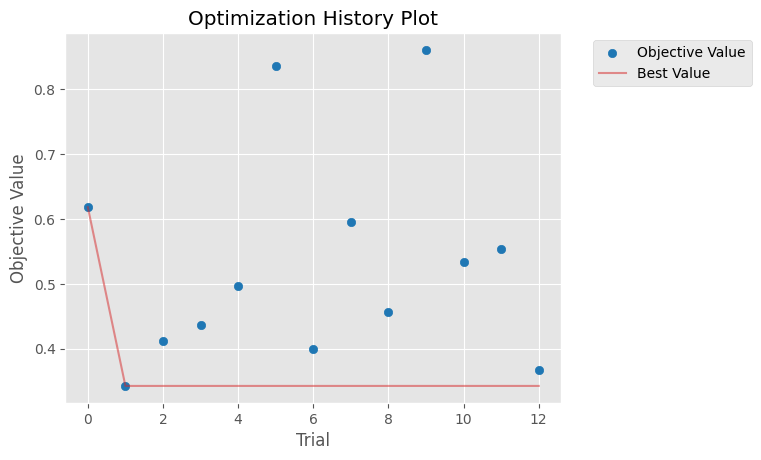

In [9]:
import optuna.visualization.matplotlib as opplt
opplt.plot_optimization_history(study)

/tmp/ipykernel_19/2166294799.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

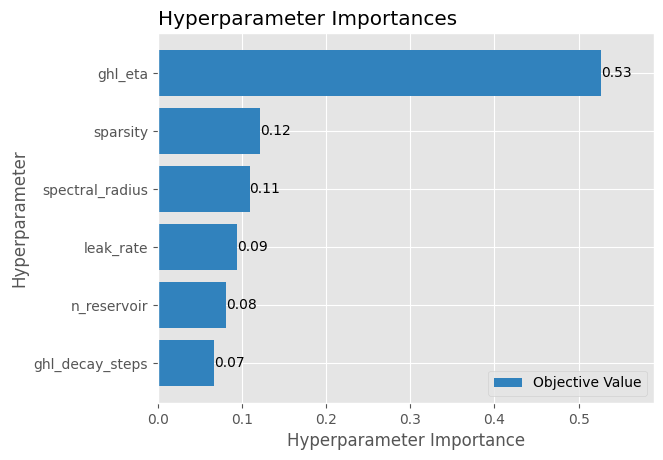

In [10]:
opplt.plot_param_importances(study)

/tmp/ipykernel_19/1148647955.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])


array([<Axes: xlabel='ghl_decay_steps', ylabel='Objective Value'>,
       <Axes: xlabel='ghl_eta'>, <Axes: xlabel='leak_rate'>,
       <Axes: xlabel='n_reservoir'>, <Axes: xlabel='sparsity'>,
       <Axes: xlabel='spectral_radius'>], dtype=object)

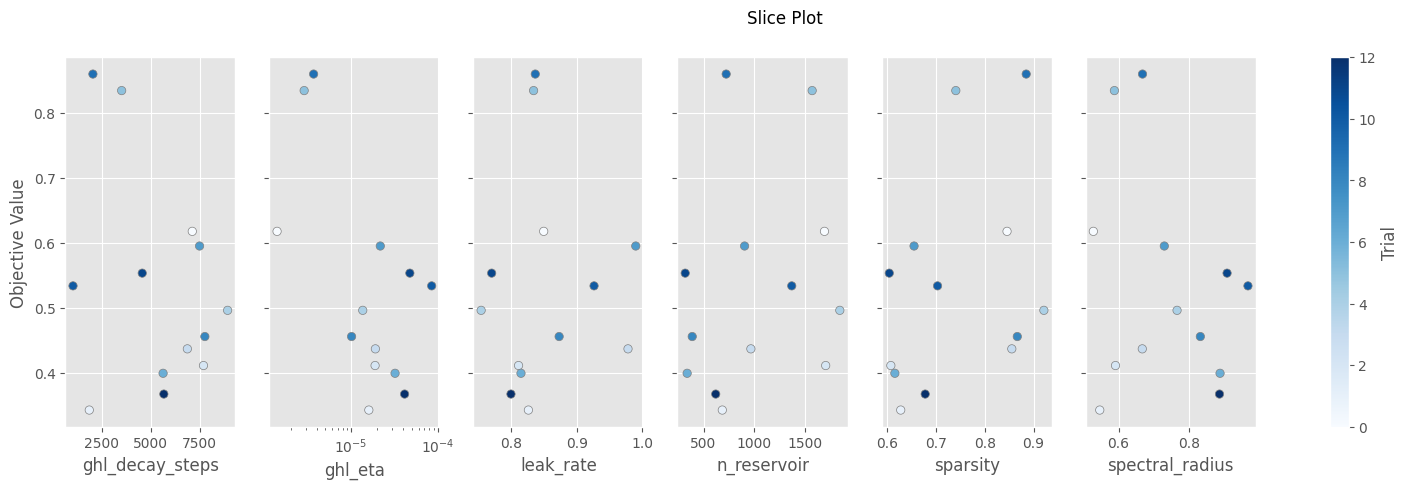

In [11]:
opplt.plot_slice(study, params=['n_reservoir', 'spectral_radius', 'sparsity', 'leak_rate', 'ghl_eta', 'ghl_decay_steps'])

In [12]:
best_params = study.best_trial.params

# In-depth Evaluation
---

In [18]:
import torch

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

fold_results = []

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
traj = len(trajectory_keys)

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)

    # Model Training
    model = pc_esn_model.PC_ESN(n_inputs=21, n_outputs=14, 
                   n_reservoir=best_params['n_reservoir'],
                   spectral_radius=best_params['spectral_radius'], 
                   sparsity=best_params['sparsity'],
                   leak_rate=best_params['leak_rate'],
                   ghl_eta=best_params['ghl_eta'],
                   ghl_decay_steps=best_params['ghl_decay_steps'],
                   device=device)
    
    model.train(X_train_t, y_train_t)
    training_time = time.time() - fold_start_time

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = model.predict_step_by_step(X_test_t)
    
    # Scenario B: Full trajectory prediction
    y_pred_full = model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)
    
    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'sbs_euclid_err': np.mean(euclid_err_step),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = utils.nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = utils.euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)
    
    fold_results.append(current_fold_results)
    traj -= 1
    print(f"Time to complete training: {(traj * (time.time()-fold_start_time))/60:.2f} minutes")
    
    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Time to complete training: 15.17 minutes

--- Fold 2/10 ---
Testing on: kukatraj10
Time to complete training: 13.36 minutes

--- Fold 3/10 ---
Testing on: kukatraj2
Time to complete training: 11.87 minutes

--- Fold 4/10 ---
Testing on: kukatraj3
Time to complete training: 10.09 minutes

--- Fold 5/10 ---
Testing on: kukatraj4
Time to complete training: 8.38 minutes

--- Fold 6/10 ---
Testing on: kukatraj5
Time to complete training: 6.72 minutes

--- Fold 7/10 ---
Testing on: kukatraj6
Time to complete training: 5.01 minutes

--- Fold 8/10 ---
Testing on: kukatraj7
Time to complete training: 3.35 minutes

--- Fold 9/10 ---
Testing on: kukatraj8
Time to complete training: 1.65 minutes

--- Fold 10/10 ---
Testing on: kukatraj9
Time to complete training: 0.00 minutes


In [20]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 16.86 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 98.64 ± 1.75
Step-by-Step Pos nMSE       | 1.7970 ± 1.3751
Step-by-Step Vel nMSE       | 5.2666 ± 2.3281
Step-by-Step Euclid Err (m) | 0.1509 ± 0.0590
Full Traj Pos nMSE          | 2.2264 ± 1.6436
Full Traj Vel nMSE          | 5.3065 ± 2.2860
Full Traj Euclid Err (m) | 0.2284 ± 0.0789
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 13820371928.9251 ± 37131901945.4003      | 0.0482 ± 0.1213
200     | 478638659.0761 ± 995381256.6396      | 0.0482 ± 0.1238
500     | 157.1367 ± 379.3664      | 0.1045 ± 0.1143
1000    | 5.9608 ± 8.4356      

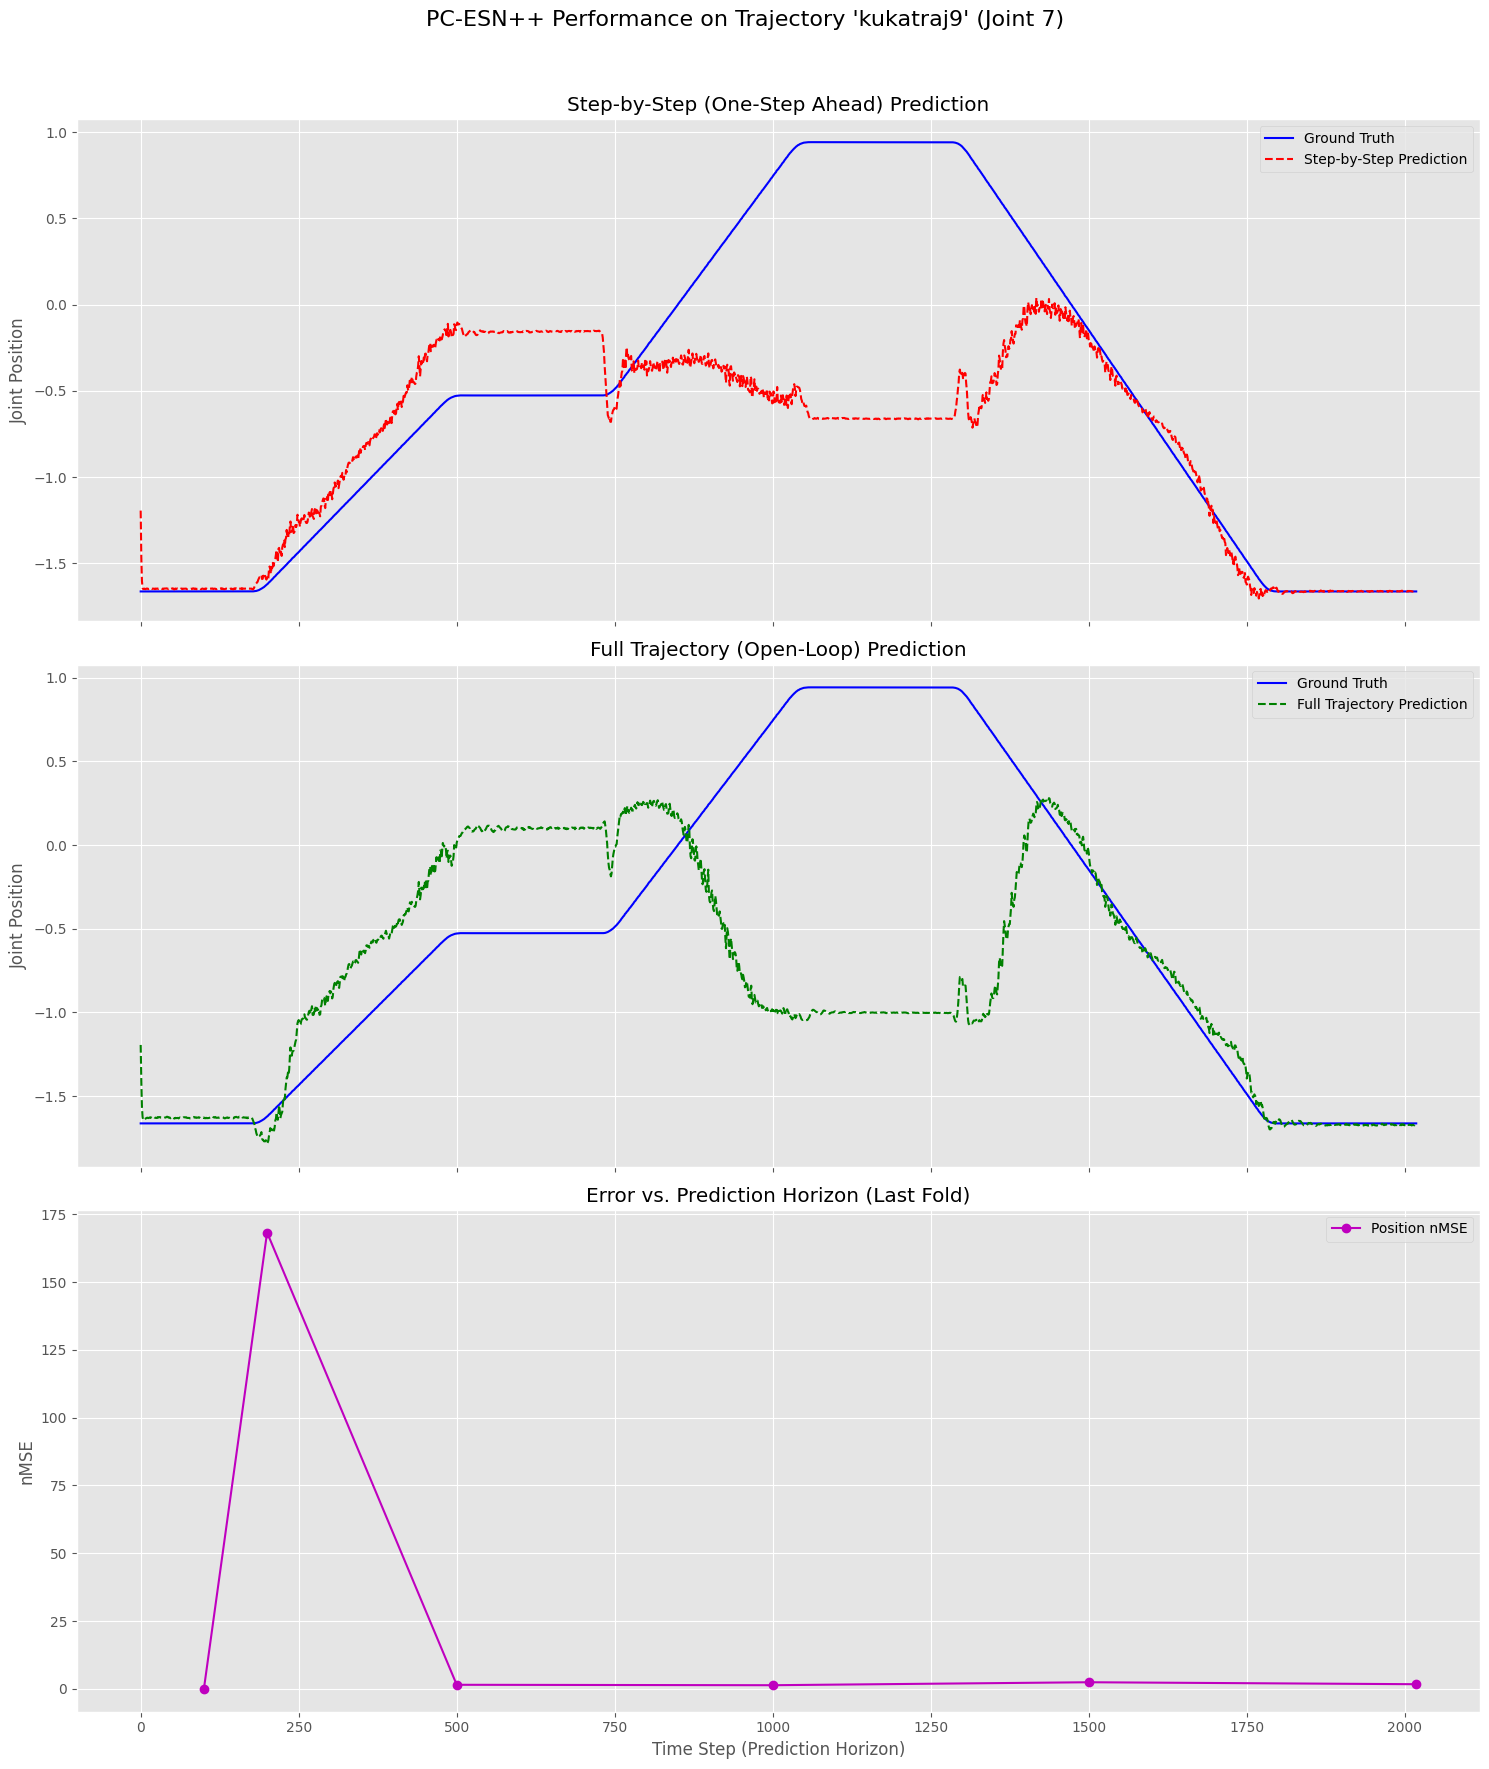

In [21]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [22]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -4.1192, P-value: 0.0026
The difference is statistically significant (p < 0.05).


(0.12480730712413787,
 1.5923509508371354,
 -1.0438732653856277,
 0.5959655195474625)

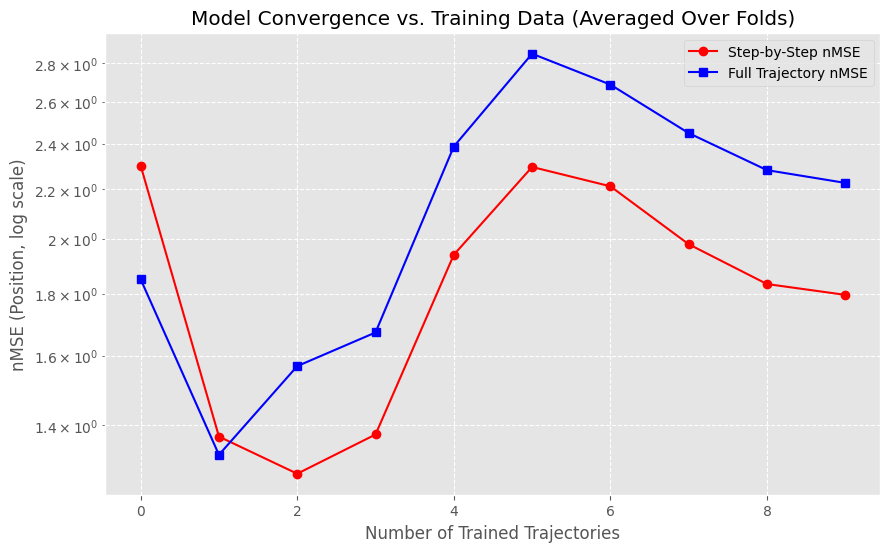

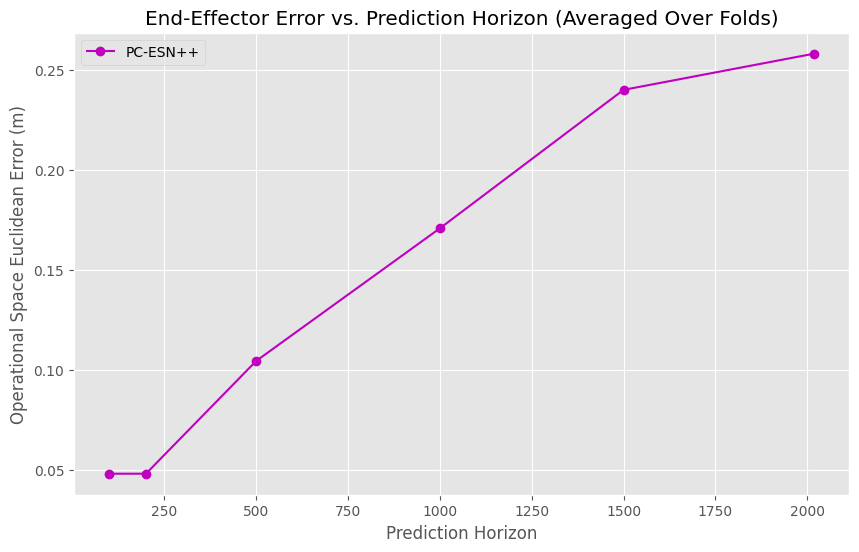

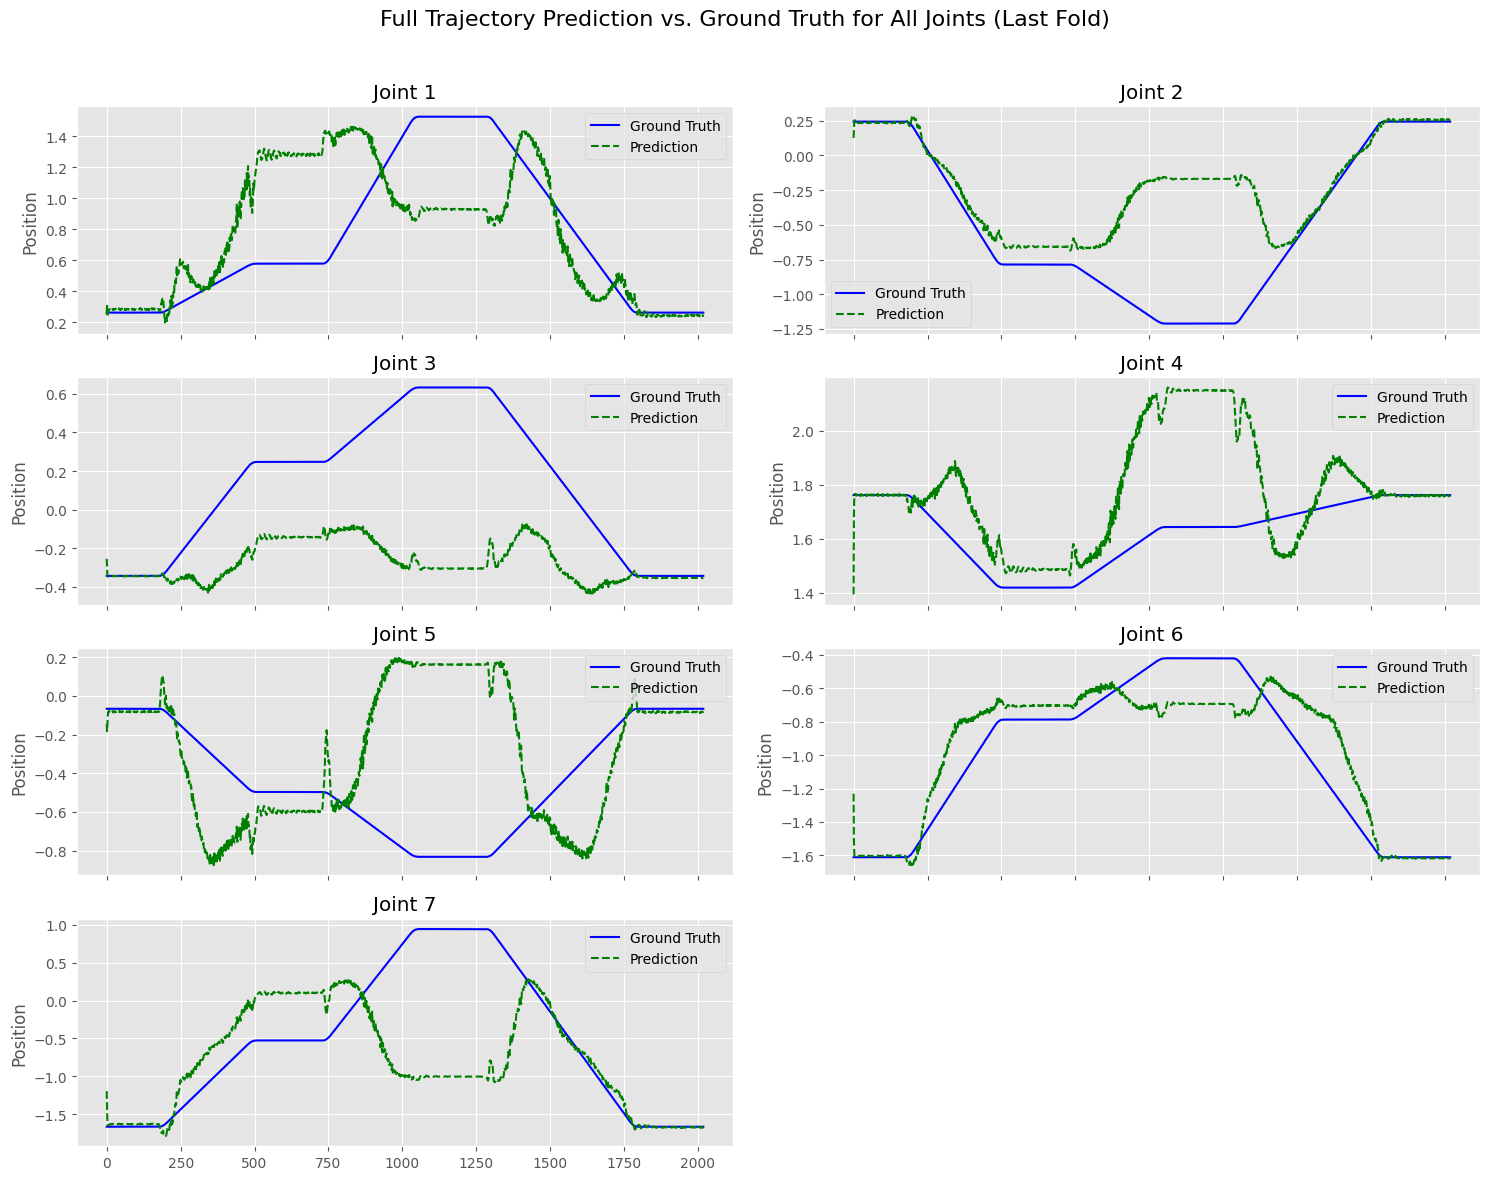

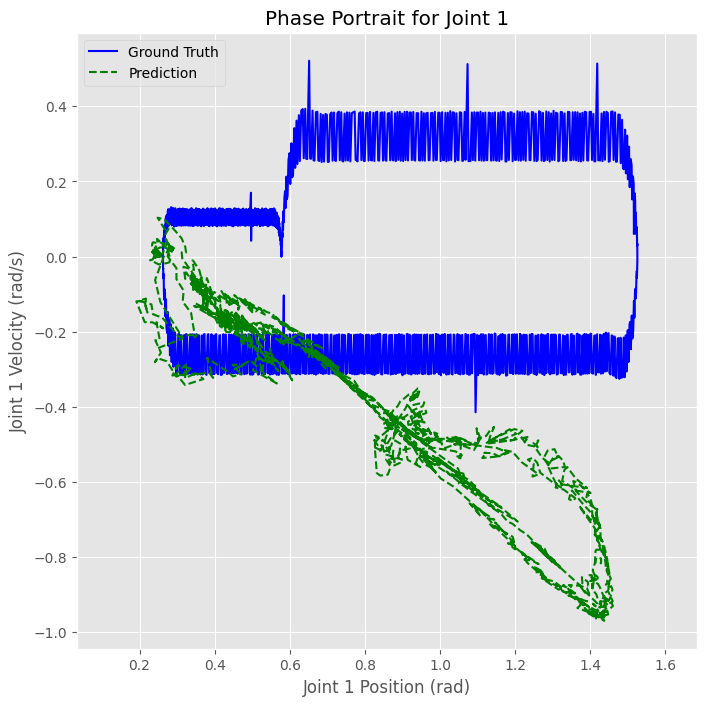

In [23]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')